In [1]:
#@title Define if we are on Colab and mount drive { display-mode: "form" }
try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
#@title (COLAB ONLY) Clone GitHub repo { display-mode: "form" }

if IN_COLAB:
  !git clone https://github.com/lluissalord/radiology_ai.git

  %cd radiology_ai

In [3]:
#@title Setup environment and Colab general variables { display-mode: "form" }
# %%capture
%run colab_setup.ipynb

In [4]:
#@title Move images from Drive to temporary folder here to be able to train models { display-mode: "form" }
# %%capture
%run move_raw_preprocess.ipynb

In [5]:
import os

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from fastai.basics import *
from fastai.callback.all import *
from fastai.data.block import *
from fastai.data.transforms import *
from fastai.vision import models
from fastai.vision.augment import *
from fastai.vision.core import PILImageBW
from fastai.vision.data import *

In [6]:
# Required to load DICOM on the fly
from preprocessing import PILDicom_scaled, init_bins, HistScaled

from utils import seed_everything, concat_templates, create_model, TestColSplitter

In [7]:
SSL_MIX_MATCH = 'MixMatch'
SSL_FIX_MATCH = 'FixMatch'

SSL = SSL_FIX_MATCH

if SSL == SSL_FIX_MATCH:
    from semisupervised.fixmatch.losses import FixMatchLoss as SSLLoss
    from semisupervised.fixmatch.callback import FixMatchCallback as SSLCallback
elif SSL == SSL_MIX_MATCH:
    from semisupervised.mixmatch.losses import MixMatchLoss as SSLLoss
    from semisupervised.mixmatch.callback import MixMatchCallback as SSLCallback

from semisupervised.ema import EMAModel

In [8]:
TEST_SIZE = 0.15
VALID_SIZE = 0.15

In [9]:
# Hyperparameters

HIST_SCALED = False
HIST_SCALED_SELF = True

CLASS_WEIGHT = False
WEIGTHED_SAMPLER = True

LR = 0.002

RESIZE = 384
RANDOM_RESIZE_CROP = 256

if SSL == SSL_FIX_MATCH:
    BATCH_SIZE = 8
    MOMENTUM = 0.9
    LAMBDA_U = 1
    MU = 5
    LABEL_THRESHOLD = 0.95

    cb_params = {}

    loss_params = {
        'bs': BATCH_SIZE,
        'mu': MU,
        'lambda_u': LAMBDA_U,
        'label_threshold': LABEL_THRESHOLD
    }
elif SSL == SSL_MIX_MATCH:
    BATCH_SIZE = 16
    LAMBDA_U = 75
    T = 0.5
    ALPHA = 0.75

    cb_params = {
        'T': T
    }

    loss_params = {
        'bs': BATCH_SIZE,
        'lambda_u': LAMBDA_U,
    }


EMA_DECAY = 0.999

MODEL = models.resnet18
# MODEL = 'efficientnet-b0'

In [10]:
SEED = 42

seed_everything(SEED)

Using seed: 42


42

In [11]:
# Transformations

item_tfms = [
    Resize(RESIZE, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    # RandomResizedCrop(RANDOM_RESIZE_CROP),
]

label_transform = [
    RandomResizedCropGPU(RANDOM_RESIZE_CROP),
    Flip(),
    # Normalize()
]

# class Multiply_255(Transform):
#     def encodes(self, o): return o * 255

unlabel_batch_tfms = [None]
if SSL == SSL_FIX_MATCH:

    weak_transform = [
        RandomResizedCropGPU(RANDOM_RESIZE_CROP),
        Flip(),
        # Multiply_255(),
        # Normalize()
    ]
    unlabel_batch_tfms.append(weak_transform)

    strong_transform = [
        RandomResizedCropGPU(RANDOM_RESIZE_CROP),
        Flip(),
        Rotate(90),
        Brightness(),
        Contrast(),
        RandomErasing(),
        # Multiply_255(),
        # Normalize()
    ]
    unlabel_batch_tfms.append(strong_transform)

elif SSL == SSL_MIX_MATCH:

    unlabel_transform = [
        RandomResizedCropGPU(RANDOM_RESIZE_CROP),
        Flip(),
        Rotate(180, p=1),
        # Multiply_255(),
        # Normalize()
    ]
    unlabel_batch_tfms.append(unlabel_transform)

In [12]:
# Callbacks
from fastai.callback.tensorboard import TensorBoardCallback

cbs = None
cbs = [
    TensorBoardCallback(),
]

In [13]:
# df = concat_templates(organize_folder, excel=True)
# df.to_excel(
#     os.path.join(PATH_PREFIX, 'all.xlsx'),
#     index=False
# )
df = pd.read_excel(os.path.join(PATH_PREFIX, 'all.xlsx'), dtype={'ID':'string','Target':'string'})

In [14]:
relation_df = pd.read_csv(os.path.join(PATH_PREFIX, 'relation.csv'))
relation_df = relation_df.set_index('Filename')

final_df = df.set_index('ID').merge(relation_df, left_index=True, right_index=True)
final_df['ID'] = final_df.index.values
final_df = final_df.reset_index(drop=True)
final_df['Raw_preprocess'] = final_df['Original_Filename'].apply(lambda filename: os.path.join(raw_preprocess_folder, filename + '.png'))

unlabel_df = final_df[df['Target'].isnull()].reset_index(drop=True)
label_df = final_df[df['Target'].notnull()].reset_index(drop=True)

In [15]:
# Data

relation_df = pd.read_csv(os.path.join(PATH_PREFIX, 'relation.csv'))
relation_df = relation_df.set_index('Filename')

final_df = df.set_index('ID').merge(relation_df, left_index=True, right_index=True)
final_df['ID'] = final_df.index.values
final_df = final_df.reset_index(drop=True)
final_df['Raw_preprocess'] = final_df['Original_Filename'].apply(lambda filename: os.path.join(raw_preprocess_folder, filename + '.png'))

unlabel_df = final_df[df['Target'].isnull()].reset_index(drop=True)
label_df = final_df[df['Target'].notnull()].reset_index(drop=True)

try:
  train_df, test_df = train_test_split(label_df, test_size=TEST_SIZE, shuffle=True, stratify=label_df['Target'], random_state=SEED)
except ValueError:
  train_df, test_df = train_test_split(label_df, test_size=TEST_SIZE, shuffle=True, random_state=SEED)

try:
  train_df, val_df = train_test_split(train_df, test_size=VALID_SIZE/(1-TEST_SIZE), shuffle=True, stratify=train_df['Target'], random_state=SEED)
except ValueError:
  train_df, val_df = train_test_split(train_df, test_size=VALID_SIZE/(1-TEST_SIZE), shuffle=True, random_state=SEED)

label_df.loc[train_df.index, 'Dataset'] = 'train'
label_df.loc[val_df.index, 'Dataset'] = 'valid'
label_df.loc[test_df.index, 'Dataset'] = 'test'

sort_dataset = {'train': 0, 'valid': 1, 'test': 2}
label_df = label_df.sort_values('Dataset', key=lambda x: x.map(sort_dataset)).reset_index(drop=True)

In [16]:
# Histogram scaling DICOM on the fly

if HIST_SCALED:
    if HIST_SCALED_SELF:
        bins = None
    else:
        # bins = init_bins(fnames=L(list(final_df['Original'].values)), n_samples=100)
        bins = init_bins(fnames=L(list(final_df['Raw_preprocess'].values)), n_samples=100, isDCM=False)
    # item_tfms.append(HistScaled(bins))
    item_tfms.append(HistScaled_all(bins))

In [17]:
base_ds_params = {
    'get_x': ColReader('Original_Filename', pref=raw_preprocess_folder+'/', suff='.png'),
    # 'get_x': ColReader('Original'),
    'item_tfms': item_tfms
}

label_ds_params = base_ds_params.copy()
# label_ds_params['blocks'] = (ImageBlock(cls=PILImageBW), MultiCategoryBlock if label_df['Target'].nunique() > 2 else CategoryBlock)
label_ds_params['blocks'] = (ImageBlock(cls=PILImageBW), CategoryBlock)
# label_ds_params['blocks'] = (ImageBlock(cls=PILDicom_scaled), MultiCategoryBlock)
label_ds_params['get_y'] = ColReader('Target')
label_ds_params['splitter'] = TestColSplitter(col='Dataset')
label_ds_params['batch_tfms'] = label_transform

unlabel_ds_params = base_ds_params.copy()
unlabel_ds_params['blocks'] = (ImageBlock(cls=PILImageBW))
# unlabel_ds_params['blocks'] = (ImageBlock(cls=PILDicom_scaled))
unlabel_ds_params['splitter'] = RandomSplitter(0)

dls_params = {
    'bs': BATCH_SIZE,
    'num_workers': 0,
    'shuffle_train': True,
    'drop_last': True
}

unlabel_dls_params = dls_params.copy()
if SSL == SSL_FIX_MATCH:
    unlabel_dls_params['bs'] = BATCH_SIZE * MU

In [18]:
# DataLoaders
print(f'==> Preparing label dataloaders')

label_dl = DataBlock(**label_ds_params).dataloaders(label_df, **dls_params)

if WEIGTHED_SAMPLER:
    # Calculate sample weights to balance the DataLoader 
    from collections import Counter

    count = Counter(label_dl.items['Target'])
    class_weights = {}
    for c in count:
        class_weights[c] = 1/count[c]
    wgts = label_dl.items['Target'].map(class_weights).values[:len(train_df)]

    # Create weigthed dataloader
    weighted_dl = DataBlock(**label_ds_params).dataloaders(label_df, **dls_params, dl_type=WeightedDL, wgts=wgts)
    label_dl.train = weighted_dl.train

print(f'==> Preparing unlabel dataloaders')

unlabel_dls = [
    DataBlock(
        **unlabel_ds_params,
        batch_tfms = batch_tfms
    ).dataloaders(unlabel_df, **unlabel_dls_params) 
    for batch_tfms in unlabel_batch_tfms
]
print(f'==> Preparing SSL callback')

ssl_cb = SSLCallback(*unlabel_dls, **cb_params)
if cbs is None:
    cbs = [ssl_cb]
else:
    cbs.append(ssl_cb)

if SSL == SSL_MIX_MATCH:
    cbs.append(MixUp(alpha=ALPHA))

==> Preparing label dataloaders
==> Preparing unlabel dataloaders
==> Preparing SSL callback


In [19]:
# Scheduling
if SSL == SSL_FIX_MATCH:
    sched = {'lr': SchedCos(LR, LR*math.cos(7*math.pi/16))}
    cbs.append(ParamScheduler(sched))
    moms = (MOMENTUM) # 0.9 according to FixMatch paper
    opt_func = SGD
else:
    opt_func = Adam

In [20]:
# Model
print("==> creating model")

classes = label_df['Target'].unique()
n_out = len(classes)

model = create_model(MODEL, n_out, pretrained=True, n_in=1)

if SSL == SSL_MIX_MATCH:
    loss_params['model'] = model

cbs.append(EMAModel(alpha=EMA_DECAY))

==> creating model


In [21]:
# Loss
print("==> defining loss")

if CLASS_WEIGHT:
    class_weight = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['Target'])
    class_weight = torch.as_tensor(class_weight).float()
    if torch.cuda.is_available():
        class_weight = class_weight.cuda()
else:
    class_weight = None

train_criterion = SSLLoss(unlabel_dl=unlabel_dls[0], n_out=n_out, weight=class_weight, **loss_params)
criterion = train_criterion.Lx_criterion

==> defining loss


In [22]:
# Learner
print("==> defining learner")

Lx_metric = AvgMetric(func=criterion)
Lu_metric = AvgMetric(func=train_criterion.Lu_criterion)

# Adapt metrics depending on the number of labels
if n_out == 2:
    average = 'binary'
    roc_auc = RocAucBinary()
else:
    average = 'macro'
    roc_auc = RocAuc()

metrics = [
    # error_rate,
    # roc_auc,
    F1Score(average=average),
    Precision(average=average),
    Recall(average=average)
]

learn = Learner(label_dl, model, loss_func=train_criterion, opt_func=opt_func, lr=LR, metrics=metrics, cbs=cbs)

==> defining learner


In [23]:
# learn.freeze()
# learn.lr_find()

In [24]:
# learn.unfreeze()
# learn.lr_find()

In [25]:
learn.fine_tune(0, 2.5E-6, freeze_epochs=1)

epoch     train_loss  valid_loss  f1_score  precision_score  recall_score  time    
0         3.522821    2.036242    0.139394  0.333333         0.088123      00:54     
epoch     train_loss  valid_loss  f1_score  precision_score  recall_score  time    


In [26]:
inputs,preds,targs,decoded,losses = learn.get_preds(dl=learn.dls[1], with_input=True, with_loss=True, with_decoded=True, act=None)

In [29]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn, ds_idx=1)
interp.plot_top_losses(k=8)

IndexError: list index out of range

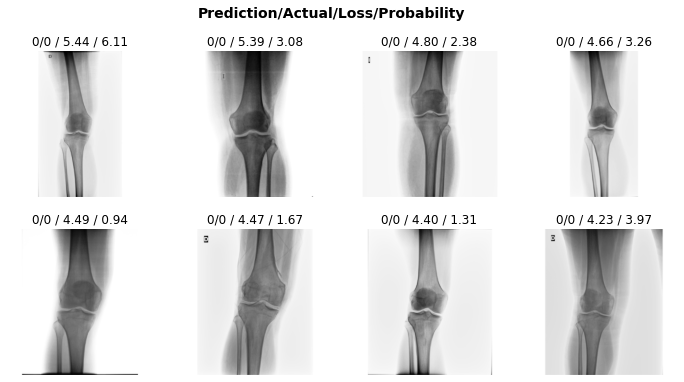

In [35]:
k=8
largest=True
losses,idx = interp.top_losses(k=8, largest=True)
if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
x,y,its = interp.dl._pre_show_batch(b, max_n=k)
# b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
b_out = b
x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
if its is not None:
    plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses)

In [33]:
b_out[1]

tensor([[ 0.6759,  0.1809,  6.1114],
        [-2.2124,  0.7527,  3.0764],
        [-2.3844, -1.2500,  2.3818],
        [-1.3812, -1.1211,  3.2579],
        [-3.2493, -0.1558,  0.9357],
        [-2.1129,  1.6349,  1.6682],
        [-2.6849,  0.5792,  1.3061],
        [-0.2354, -0.8659,  3.9685]])

In [47]:
idx

tensor([22, 51, 29, 12, 53, 18, 48, 54])

In [55]:
a = (interp.decoded if is_listy(interp.decoded) else (interp.decoded,))
for o in a:
    print(o[idx])

tensor([[ 3.3027,  0.6086],
        [ 0.9059, -0.9891],
        [ 1.6173, -0.5411],
        [ 2.1005, -0.1493],
        [ 4.4745,  2.1660],
        [ 2.2424, -0.5084],
        [ 4.4622,  1.6442],
        [ 3.3246,  0.3774]])


In [40]:
b

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [37]:
b_out

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..